# 🔬 SimCLR Self-Supervised Pretraining for YOLO Object Detection

**Assignment 2: Self-Supervised Learning - Phase 1: Pretraining**

This notebook implements **SimCLR** (A Simple Framework for Contrastive Learning) to pretrain a backbone that will be used to initialize **YOLOv12** for Brain MRI object detection. Following the teacher's example pattern.

---

## 📋 Pipeline Overview

| # | Step | Description | Output |
|---|------|-------------|--------|
| **1** | Environment Setup | Install dependencies, configure GPU/MPS/CPU | Ready environment |
| **2** | Data Loading | Load Brain MRI images (unlabeled) for SSL | TwoView dataset |
| **3** | SimCLR Architecture | Build encoder + projection head | SimCLR model |
| **4** | NT-Xent Loss | Implement contrastive loss function | Loss function |
| **5** | Pretraining | Train with contrastive learning (20 epochs) | Pretrained backbone |
| **6** | Save Weights | Export backbone for YOLO integration | `simclr_backbone.pth` |
| **7** | Feature Analysis | t-SNE visualization of learned features | Feature plots |

---

## 📚 Table of Contents

1. [Introduction & Theory](#1-introduction--theory)
2. [Environment Setup](#2-environment-setup)
3. [Configuration](#3-configuration)
4. [Data Loading & Augmentation](#4-data-loading--augmentation)
5. [SimCLR Architecture](#5-simclr-architecture)
6. [NT-Xent Contrastive Loss](#6-nt-xent-contrastive-loss)
7. [Pretraining Loop](#7-pretraining-loop)
8. [Training Visualization](#8-training-visualization)
9. [Save Pretrained Model](#9-save-pretrained-model)
10. [Feature Quality Analysis](#10-feature-quality-analysis)

---

## 1. Introduction & Theory

### What is Self-Supervised Learning?
Self-Supervised Learning (SSL) is a paradigm where models learn representations from **unlabeled data** by solving pretext tasks. This is crucial for domains like medical imaging where labeled data is scarce and expensive.

### What is SimCLR?
SimCLR learns representations by **maximizing agreement** between differently augmented views of the same image via a contrastive loss.

### Key Components:
1. **Data Augmentation Pipeline**: Creates two augmented views of each image
2. **Base Encoder f(·)**: ResNet backbone that extracts features
3. **Projection Head g(·)**: MLP that projects features to contrastive space
4. **NT-Xent Loss**: Normalized Temperature-scaled Cross-Entropy Loss

### SimCLR Architecture:
```
                    Image x
                       │
         ┌─────────────┴─────────────┐
         ▼                           ▼
    ┌─────────┐                 ┌─────────┐
    │  Aug t  │                 │  Aug t' │
    │ (view1) │                 │ (view2) │
    └────┬────┘                 └────┬────┘
         │                           │
         ▼                           ▼
    ┌─────────┐                 ┌─────────┐
    │  f(·)   │   Encoder       │  f(·)   │
    │ ResNet  │   (shared)      │ ResNet  │
    └────┬────┘                 └────┬────┘
         │ h_i                       │ h_j
         ▼                           ▼
    ┌─────────┐                 ┌─────────┐
    │  g(·)   │   Projection    │  g(·)   │
    │   MLP   │   (shared)      │   MLP   │
    └────┬────┘                 └────┬────┘
         │ z_i                       │ z_j
         └───────────┬───────────────┘
                     ▼
              NT-Xent Loss
         (Contrastive Learning)
```

### What This Notebook Produces:
- **`simclr_pretrained_encoder.pth`**: Pretrained ResNet encoder weights
- **Training curves**: Loss over epochs
- **Feature visualizations**: t-SNE of learned representations

The saved encoder will be used in the **Finetuning notebook** for downstream tasks.

## 2. Environment Setup

In [1]:
# ============================================
# IMPORTS
# ============================================

import os
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from tqdm.auto import tqdm
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image

# Sklearn for visualization
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Seaborn
try:
    import seaborn as sns
    sns.set_style('whitegrid')
    HAS_SEABORN = True
except:
    HAS_SEABORN = False

# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)

set_seed(42)

# ==================================
# DEVICE SELECTION (CUDA > MPS > CPU)
# ==================================
def get_device():
    """Get the best available device."""
    if torch.cuda.is_available():
        device = torch.device('cuda')
        device_name = torch.cuda.get_device_name(0)
        memory = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"🖥️  Device: CUDA")
        print(f"   GPU: {device_name}")
        print(f"   Memory: {memory:.2f} GB")
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        device = torch.device('mps')
        print(f"🖥️  Device: MPS (Apple Silicon)")
        print(f"   Note: Some operations may fall back to CPU on MPS")
    else:
        device = torch.device('cpu')
        print(f"🖥️  Device: CPU")
    return device

device = get_device()

# Environment detection
IS_KAGGLE = os.path.exists('/kaggle/input')
IS_COLAB = 'google.colab' in str(get_ipython()) if 'get_ipython' in dir() else False

print(f"📍 Environment: {'🌐 Kaggle' if IS_KAGGLE else '🔬 Colab' if IS_COLAB else '💻 Local'}")
print(f"🐍 PyTorch Version: {torch.__version__}")
print("\n✅ All imports successful!")

🖥️  Device: CUDA
   GPU: Tesla T4
   Memory: 15.83 GB
📍 Environment: 🌐 Kaggle
🐍 PyTorch Version: 2.6.0+cu124

✅ All imports successful!


## 3. Configuration

In [2]:
# ============================================
# 🔧 CONFIGURATION
# ============================================

class Config:
    """SimCLR Pretraining Configuration for YOLO Integration"""
    
    # ==================================
    # PATH CONFIGURATION
    # ==================================
    if IS_KAGGLE:
        DATASET_NAME = 'brain-mri-split-dataset-v2/brain-mri-split-dataset-v2'
        DATA_DIR = Path(f'/kaggle/input/{DATASET_NAME}/dataset')
        OUTPUT_DIR = Path('/kaggle/working/03_1_SimCLR_Pretraining')
        # YOLOv12 weights included in dataset
        YOLOV12_WEIGHTS = Path(f'/kaggle/input/{DATASET_NAME}/yolov12-best.pt')
    else:
        DATA_DIR = Path('e:/EWU University/10th Semester/CSE475/Brain MRI/brain-mri-split-dataset-v2/dataset')
        OUTPUT_DIR = Path('e:/EWU University/10th Semester/CSE475/Brain MRI/Assignment V2/outputs/03_1_SimCLR_Pretraining')
        YOLOV12_WEIGHTS = Path('e:/EWU University/10th Semester/CSE475/Brain MRI/brain-mri-split-dataset-v2/yolov12-best.pt')
    
    # Model architecture
    BACKBONE = 'resnet18'  # Options: 'resnet18', 'resnet34', 'resnet50'
    PROJECTION_DIM = 128   # Dimension of projection head output
    HIDDEN_DIM = 512       # Hidden dimension in projection head
    
    # Training hyperparameters
    EPOCHS = 100            # Epochs for SSL pretraining (like teacher's example)
    BATCH_SIZE = 32        # Batch size for contrastive learning
    LEARNING_RATE = 1e-3   # Learning rate
    WEIGHT_DECAY = 1e-4    # L2 regularization
    TEMPERATURE = 0.2      # Temperature for NT-Xent loss (like teacher's example)
    
    # Image settings
    IMG_SIZE = 224
    
    # Augmentation strength
    COLOR_JITTER_S = 0.4
    
    # Logging
    LOG_INTERVAL = 5
    SAVE_INTERVAL = 10
    
    # Output files
    MODEL_SAVE_NAME = 'simclr_backbone.pth'  # For YOLO integration
    FULL_MODEL_SAVE_NAME = 'simclr_full_model.pth'

config = Config()
config.OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# ==================================
# PRINT CONFIGURATION
# ==================================
print("=" * 70)
print("📋 SIMCLR PRETRAINING CONFIGURATION (For YOLO Integration)")
print("=" * 70)
print(f"  📍 Environment:     {'🌐 Kaggle' if IS_KAGGLE else '💻 Local'}")
print(f"  📂 Data Directory:  {config.DATA_DIR}")
print(f"  📁 Output Directory: {config.OUTPUT_DIR}")
print(f"  🔧 YOLOv12 Weights: {config.YOLOV12_WEIGHTS}")
print(f"  🏗️  Backbone:         {config.BACKBONE}")
print(f"  📐 Projection Dim:  {config.PROJECTION_DIM}")
print(f"  🔄 Epochs:          {config.EPOCHS}")
print(f"  📦 Batch Size:      {config.BATCH_SIZE}")
print(f"  📈 Learning Rate:   {config.LEARNING_RATE}")
print(f"  🌡️  Temperature:      {config.TEMPERATURE}")
print("=" * 70)

# Verify data path
if config.DATA_DIR.exists():
    train_img_dir = config.DATA_DIR / 'train' / 'images'
    if train_img_dir.exists():
        img_count = len(list(train_img_dir.glob('*.jpg')) + list(train_img_dir.glob('*.png')))
        print(f"\n✅ Data found: {img_count} training images")
    else:
        print(f"\n⚠️ Train images not found at {train_img_dir}")
else:
    print(f"\n❌ Data directory not found: {config.DATA_DIR}")

📋 SIMCLR PRETRAINING CONFIGURATION (For YOLO Integration)
  📍 Environment:     🌐 Kaggle
  📂 Data Directory:  /kaggle/input/brain-mri-split-dataset-v2/brain-mri-split-dataset-v2/dataset
  📁 Output Directory: /kaggle/working/03_1_SimCLR_Pretraining
  🔧 YOLOv12 Weights: /kaggle/input/brain-mri-split-dataset-v2/brain-mri-split-dataset-v2/yolov12-best.pt
  🏗️  Backbone:         resnet18
  📐 Projection Dim:  128
  🔄 Epochs:          100
  📦 Batch Size:      32
  📈 Learning Rate:   0.001
  🌡️  Temperature:      0.2

✅ Data found: 1810 training images


## 4. Data Loading & Augmentation

### SimCLR Augmentation Strategy
The key insight of SimCLR is that **strong data augmentation** is crucial for learning good representations. We apply:
- Random resized crop
- Random horizontal flip
- Color jitter (brightness, contrast, saturation, hue)
- Random grayscale
- Gaussian blur

In [3]:
class SimCLRAugmentation:
    """
    SimCLR-style augmentation pipeline.
    Returns TWO differently augmented views of the same image.
    """
    
    def __init__(self, size=224, s=0.5):
        """
        Args:
            size: Output image size
            s: Color jitter strength
        """
        # Color jitter with controlled strength
        color_jitter = transforms.ColorJitter(
            brightness=0.8 * s,
            contrast=0.8 * s,
            saturation=0.8 * s,
            hue=0.2 * s
        )
        
        # Gaussian blur kernel size (must be odd)
        blur_kernel = int(0.1 * size)
        if blur_kernel % 2 == 0:
            blur_kernel += 1
        
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(size=size, scale=(0.2, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply([color_jitter], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.GaussianBlur(kernel_size=blur_kernel, sigma=(0.1, 2.0)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
    
    def __call__(self, x):
        """Return two different augmented views."""
        return self.transform(x), self.transform(x)


class SimCLRDataset(Dataset):
    """
    Dataset for SimCLR pretraining.
    Returns pairs of augmented views (no labels needed).
    """
    
    def __init__(self, img_dir, transform=None):
        self.img_dir = Path(img_dir)
        self.image_files = (
            list(self.img_dir.glob('*.jpg')) + 
            list(self.img_dir.glob('*.png')) +
            list(self.img_dir.glob('*.jpeg'))
        )
        self.transform = transform
        print(f"📁 Loaded {len(self.image_files)} images from {img_dir}")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            view1, view2 = self.transform(image)
        else:
            view1 = view2 = transforms.ToTensor()(image)
        
        return view1, view2


print("✅ Dataset classes defined!")

✅ Dataset classes defined!


In [4]:
# Create datasets and dataloaders
simclr_augment = SimCLRAugmentation(size=config.IMG_SIZE, s=config.COLOR_JITTER_S)

# Use training images for pretraining
train_img_dir = config.DATA_DIR / 'train' / 'images'

train_dataset = SimCLRDataset(train_img_dir, transform=simclr_augment)

train_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=True,
    num_workers=2 if IS_KAGGLE else 0,
    pin_memory=True,
    drop_last=True  # Important for contrastive learning
)

print(f"\n📊 Dataset Statistics:")
print(f"   Training images: {len(train_dataset)}")
print(f"   Batches per epoch: {len(train_loader)}")
print(f"   Effective batch size: {config.BATCH_SIZE}")

📁 Loaded 1810 images from /kaggle/input/brain-mri-split-dataset-v2/brain-mri-split-dataset-v2/dataset/train/images

📊 Dataset Statistics:
   Training images: 1810
   Batches per epoch: 56
   Effective batch size: 32


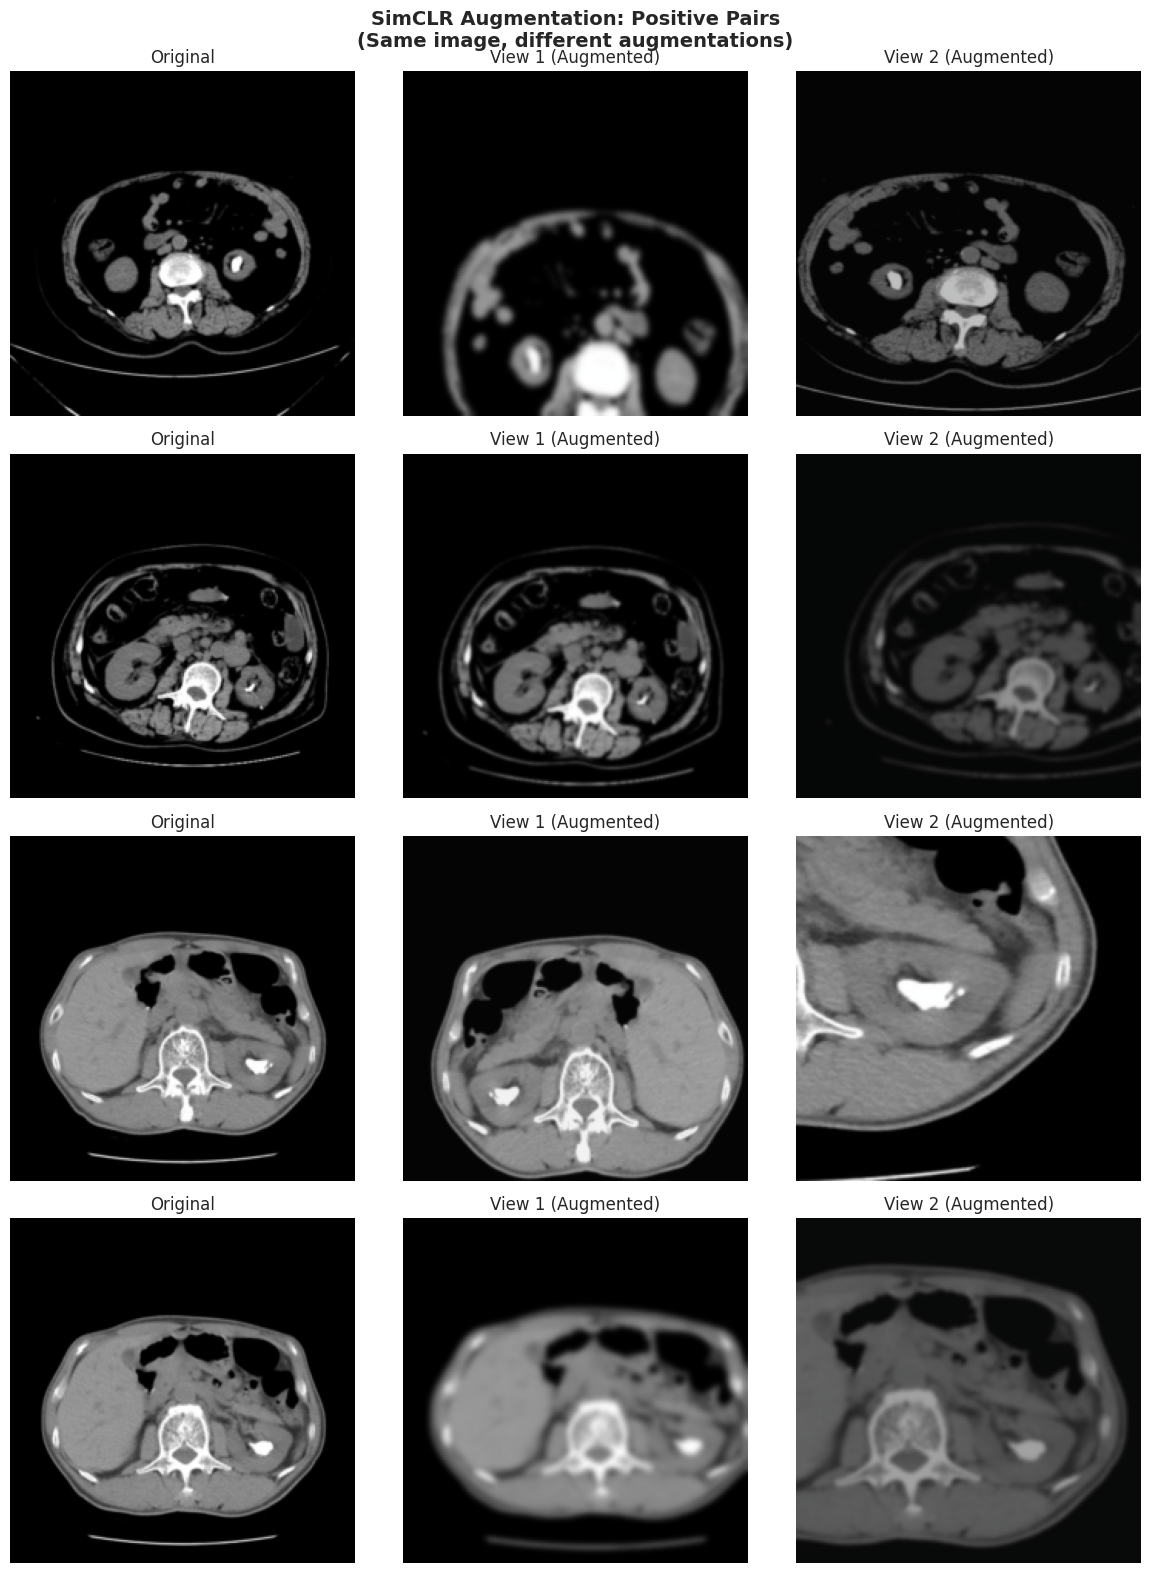

💾 Saved: /kaggle/working/03_1_SimCLR_Pretraining/simclr_augmentation_pairs.png


In [5]:
# Visualize augmentation pairs
def visualize_augmentations(dataset, num_samples=4):
    """
    Visualize pairs of augmented views.
    This helps verify that augmentations are working correctly.
    """
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    
    # ImageNet normalization stats
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # Get original images (without augmentation)
    orig_transform = transforms.Compose([
        transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
        transforms.ToTensor()
    ])
    
    indices = random.sample(range(len(dataset)), num_samples)
    
    for i, idx in enumerate(indices):
        # Get augmented views
        view1, view2 = dataset[idx]
        
        # Denormalize for display
        view1_show = view1.numpy().transpose(1, 2, 0) * std + mean
        view2_show = view2.numpy().transpose(1, 2, 0) * std + mean
        
        # Get original
        orig_img = Image.open(dataset.image_files[idx]).convert('RGB')
        orig_img = orig_transform(orig_img).numpy().transpose(1, 2, 0)
        
        # Plot
        axes[i, 0].imshow(np.clip(orig_img, 0, 1))
        axes[i, 0].set_title('Original', fontsize=12)
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(np.clip(view1_show, 0, 1))
        axes[i, 1].set_title('View 1 (Augmented)', fontsize=12)
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(np.clip(view2_show, 0, 1))
        axes[i, 2].set_title('View 2 (Augmented)', fontsize=12)
        axes[i, 2].axis('off')
    
    plt.suptitle('SimCLR Augmentation: Positive Pairs\n(Same image, different augmentations)', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(config.OUTPUT_DIR / 'simclr_augmentation_pairs.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"💾 Saved: {config.OUTPUT_DIR / 'simclr_augmentation_pairs.png'}")

visualize_augmentations(train_dataset)

### 4.1 Dataset EDA & Statistics

Let's analyze the training dataset before augmentation.

📊 DATASET EXPLORATORY DATA ANALYSIS


Analyzing images:   0%|          | 0/200 [00:00<?, ?it/s]

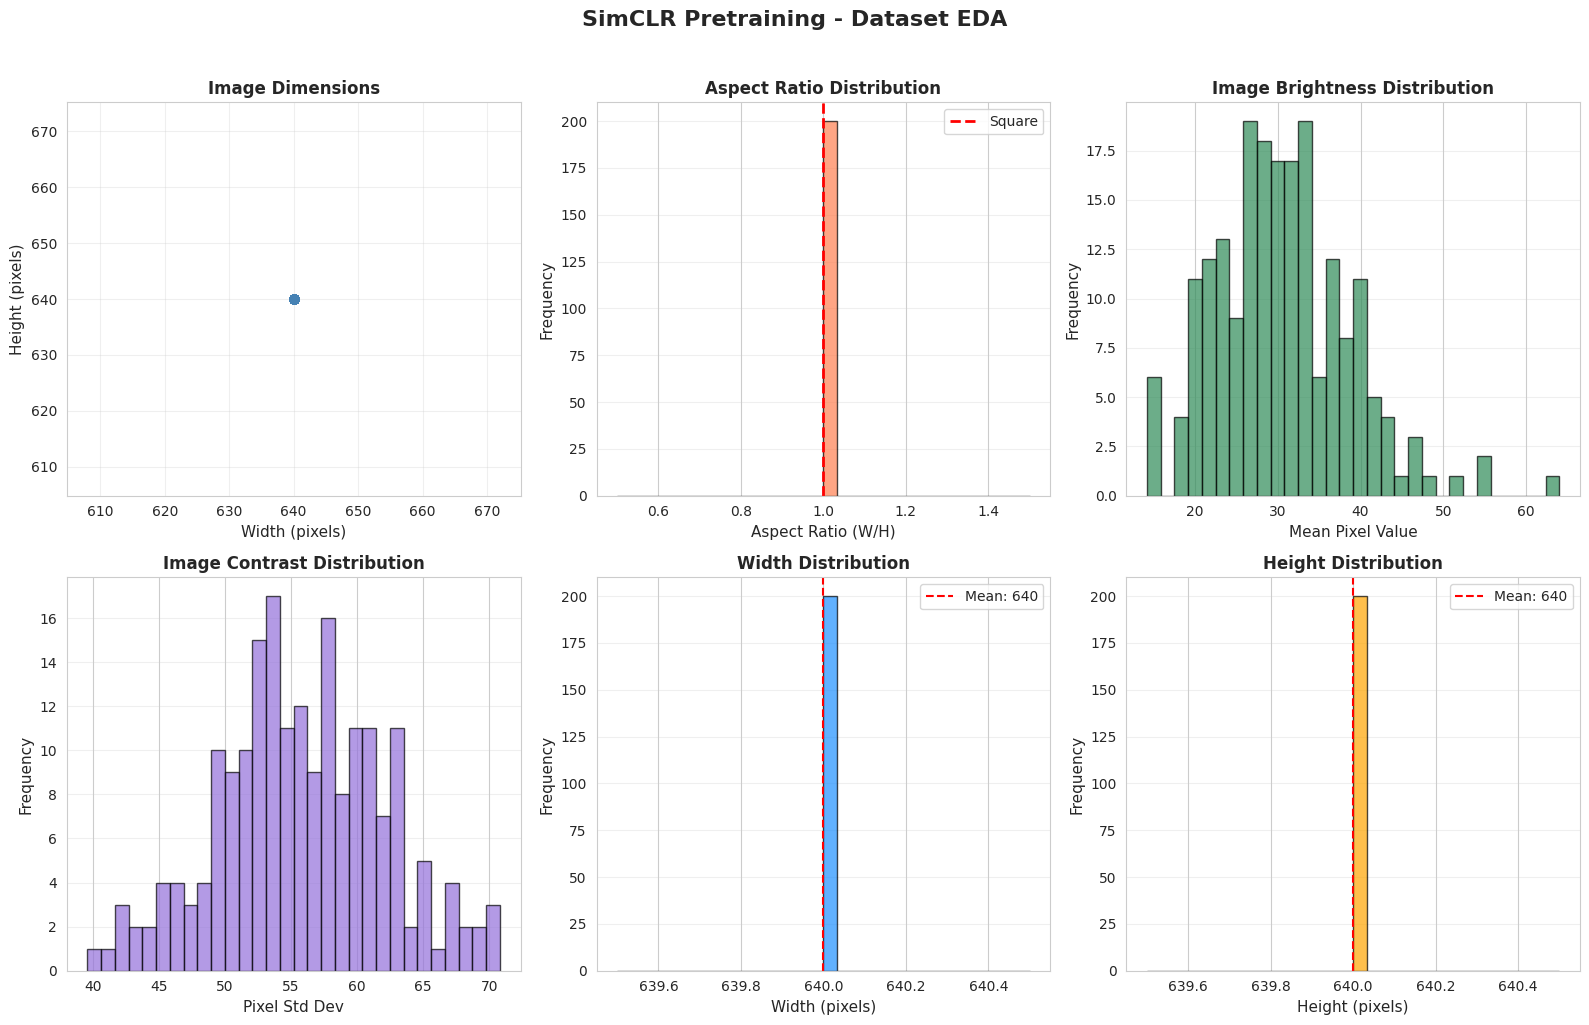


💾 Saved: /kaggle/working/03_1_SimCLR_Pretraining/simclr_dataset_eda.png

📊 IMAGE STATISTICS (from sample):
   Mean Width:  640 ± 0 px
   Mean Height: 640 ± 0 px
   Mean Aspect: 1.00
   Mean Brightness: 30.5
   Mean Contrast: 55.8


In [6]:
# ==================================
# DATASET EDA
# ==================================
print("=" * 70)
print("📊 DATASET EXPLORATORY DATA ANALYSIS")
print("=" * 70)

# Analyze image properties
def analyze_images(img_dir, sample_size=100):
    """Analyze image properties from directory."""
    img_files = list(img_dir.glob('*.jpg')) + list(img_dir.glob('*.png'))
    
    widths, heights, aspects = [], [], []
    mean_pixels, std_pixels = [], []
    
    sample_files = random.sample(img_files, min(sample_size, len(img_files)))
    
    for img_path in tqdm(sample_files, desc="Analyzing images"):
        try:
            img = Image.open(img_path).convert('RGB')
            w, h = img.size
            widths.append(w)
            heights.append(h)
            aspects.append(w / h if h > 0 else 1)
            
            # Calculate mean pixel value
            img_array = np.array(img)
            mean_pixels.append(img_array.mean())
            std_pixels.append(img_array.std())
        except:
            pass
    
    return {
        'widths': widths, 'heights': heights, 'aspects': aspects,
        'mean_pixels': mean_pixels, 'std_pixels': std_pixels
    }

train_img_dir = config.DATA_DIR / 'train' / 'images'
stats = analyze_images(train_img_dir, sample_size=200)

# Create EDA plots
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Image Size Distribution
ax = axes[0, 0]
ax.scatter(stats['widths'], stats['heights'], alpha=0.5, c='steelblue', s=40)
ax.set_xlabel('Width (pixels)', fontsize=11)
ax.set_ylabel('Height (pixels)', fontsize=11)
ax.set_title('Image Dimensions', fontweight='bold')
ax.grid(True, alpha=0.3)

# 2. Aspect Ratio Distribution
ax = axes[0, 1]
ax.hist(stats['aspects'], bins=30, color='coral', edgecolor='black', alpha=0.7)
ax.axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='Square')
ax.set_xlabel('Aspect Ratio (W/H)', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Aspect Ratio Distribution', fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# 3. Mean Pixel Value Distribution
ax = axes[0, 2]
ax.hist(stats['mean_pixels'], bins=30, color='seagreen', edgecolor='black', alpha=0.7)
ax.set_xlabel('Mean Pixel Value', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Image Brightness Distribution', fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# 4. Pixel Standard Deviation
ax = axes[1, 0]
ax.hist(stats['std_pixels'], bins=30, color='mediumpurple', edgecolor='black', alpha=0.7)
ax.set_xlabel('Pixel Std Dev', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Image Contrast Distribution', fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# 5. Width Distribution
ax = axes[1, 1]
ax.hist(stats['widths'], bins=30, color='dodgerblue', edgecolor='black', alpha=0.7)
ax.axvline(x=np.mean(stats['widths']), color='red', linestyle='--', 
           label=f'Mean: {np.mean(stats["widths"]):.0f}')
ax.set_xlabel('Width (pixels)', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Width Distribution', fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# 6. Height Distribution
ax = axes[1, 2]
ax.hist(stats['heights'], bins=30, color='orange', edgecolor='black', alpha=0.7)
ax.axvline(x=np.mean(stats['heights']), color='red', linestyle='--', 
           label=f'Mean: {np.mean(stats["heights"]):.0f}')
ax.set_xlabel('Height (pixels)', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Height Distribution', fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.suptitle('SimCLR Pretraining - Dataset EDA', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / 'simclr_dataset_eda.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n💾 Saved: {config.OUTPUT_DIR / 'simclr_dataset_eda.png'}")

# Summary statistics
print(f"\n📊 IMAGE STATISTICS (from sample):")
print(f"   Mean Width:  {np.mean(stats['widths']):.0f} ± {np.std(stats['widths']):.0f} px")
print(f"   Mean Height: {np.mean(stats['heights']):.0f} ± {np.std(stats['heights']):.0f} px")
print(f"   Mean Aspect: {np.mean(stats['aspects']):.2f}")
print(f"   Mean Brightness: {np.mean(stats['mean_pixels']):.1f}")
print(f"   Mean Contrast: {np.mean(stats['std_pixels']):.1f}")

### Understanding the Visualization Above:
- **Original**: The input image before any augmentation
- **View 1 & View 2**: Two different augmented versions of the same image
- These form a **positive pair** - the model learns that these should have similar representations
- Views from **different images** form **negative pairs** - their representations should be dissimilar

## 5. SimCLR Architecture

In [7]:
class SimCLR(nn.Module):
    """
    SimCLR Model: Encoder + Projection Head
    
    The encoder learns general visual representations.
    The projection head maps features to a space where contrastive loss is applied.
    
    After pretraining:
    - KEEP the encoder for downstream tasks
    - DISCARD the projection head
    """
    
    def __init__(self, backbone='resnet18', projection_dim=128, hidden_dim=512):
        super(SimCLR, self).__init__()
        
        # Load backbone
        if backbone == 'resnet18':
            self.encoder = models.resnet18(pretrained=False)
            self.feature_dim = 512
        elif backbone == 'resnet34':
            self.encoder = models.resnet34(pretrained=False)
            self.feature_dim = 512
        elif backbone == 'resnet50':
            self.encoder = models.resnet50(pretrained=False)
            self.feature_dim = 2048
        else:
            raise ValueError(f"Unknown backbone: {backbone}")
        
        # Remove the final FC layer from encoder
        self.encoder.fc = nn.Identity()
        
        # Projection head: MLP with one hidden layer
        # g(h) = W(2) * ReLU(BN(W(1) * h))
        self.projection_head = nn.Sequential(
            nn.Linear(self.feature_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, projection_dim)
        )
        
        self.backbone_name = backbone
        self.projection_dim = projection_dim
    
    def forward(self, x):
        """
        Forward pass.
        
        Returns:
            h: Features from encoder (for downstream tasks)
            z: Projections (for contrastive loss)
        """
        h = self.encoder(x)  # Features: (batch, feature_dim)
        z = self.projection_head(h)  # Projections: (batch, projection_dim)
        return h, z
    
    def get_encoder(self):
        """Get the encoder for downstream tasks."""
        return self.encoder


# Create model
model = SimCLR(
    backbone=config.BACKBONE,
    projection_dim=config.PROJECTION_DIM,
    hidden_dim=config.HIDDEN_DIM
).to(device)

# Model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("="*60)
print("🏗️ SIMCLR MODEL ARCHITECTURE")
print("="*60)
print(f"  Backbone: {config.BACKBONE}")
print(f"  Feature dimension: {model.feature_dim}")
print(f"  Projection dimension: {config.PROJECTION_DIM}")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print("="*60)

🏗️ SIMCLR MODEL ARCHITECTURE
  Backbone: resnet18
  Feature dimension: 512
  Projection dimension: 128
  Total parameters: 11,505,856
  Trainable parameters: 11,505,856


## 6. NT-Xent Contrastive Loss

### Loss Function Explanation:
The NT-Xent (Normalized Temperature-scaled Cross-Entropy) loss encourages:
- **Positive pairs** (two views of same image) → **similar** representations
- **Negative pairs** (views from different images) → **dissimilar** representations

$$\mathcal{L}_{i,j} = -\log \frac{\exp(\text{sim}(z_i, z_j) / \tau)}{\sum_{k=1}^{2N} \mathbb{1}_{[k \neq i]} \exp(\text{sim}(z_i, z_k) / \tau)}$$

Where:
- $\text{sim}(u, v) = u^T v / (\|u\| \|v\|)$ is cosine similarity
- $\tau$ is the temperature parameter
- $N$ is the batch size

In [8]:
class NTXentLoss(nn.Module):
    """
    Normalized Temperature-scaled Cross-Entropy Loss (NT-Xent)
    
    This is the core loss function for SimCLR contrastive learning.
    """
    
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss(reduction='mean')
    
    def forward(self, z_i, z_j):
        """
        Compute NT-Xent loss.
        
        Args:
            z_i: Projections from view 1, shape (batch_size, projection_dim)
            z_j: Projections from view 2, shape (batch_size, projection_dim)
        
        Returns:
            loss: Scalar loss value
        """
        batch_size = z_i.shape[0]
        
        # Normalize projections to unit vectors
        z_i = F.normalize(z_i, dim=1)
        z_j = F.normalize(z_j, dim=1)
        
        # Concatenate to form 2N representations
        representations = torch.cat([z_i, z_j], dim=0)  # (2N, projection_dim)
        
        # Compute similarity matrix: (2N, 2N)
        similarity_matrix = torch.matmul(representations, representations.T) / self.temperature
        
        # Create labels: for each sample, the positive is at index (i + N) or (i - N)
        # Sample 0's positive is at index N, sample 1's positive is at N+1, etc.
        labels = torch.cat([
            torch.arange(batch_size, 2 * batch_size),  # First half points to second half
            torch.arange(0, batch_size)                 # Second half points to first half
        ], dim=0).to(device)
        
        # Mask out self-similarity (diagonal)
        mask = torch.eye(2 * batch_size, dtype=torch.bool).to(device)
        similarity_matrix = similarity_matrix.masked_fill(mask, -9e15)
        
        # Compute cross-entropy loss
        loss = self.criterion(similarity_matrix, labels)
        
        return loss


# Create loss function
criterion = NTXentLoss(temperature=config.TEMPERATURE)

# Create optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr=config.LEARNING_RATE,
    weight_decay=config.WEIGHT_DECAY
)

# Learning rate scheduler (cosine annealing)
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=config.EPOCHS,
    eta_min=1e-6
)

print("✅ Loss function and optimizer configured!")
print(f"   Temperature: {config.TEMPERATURE}")
print(f"   Initial LR: {config.LEARNING_RATE}")
print(f"   Scheduler: Cosine Annealing")

✅ Loss function and optimizer configured!
   Temperature: 0.2
   Initial LR: 0.001
   Scheduler: Cosine Annealing


## 7. Pretraining Loop

In [9]:
def train_epoch(model, dataloader, criterion, optimizer, epoch):
    """
    Train for one epoch.
    
    Returns:
        avg_loss: Average loss for the epoch
    """
    model.train()
    total_loss = 0
    num_batches = 0
    
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{config.EPOCHS}")
    
    for batch_idx, (view1, view2) in enumerate(progress_bar):
        view1 = view1.to(device)
        view2 = view2.to(device)
        
        # Forward pass
        _, z_i = model(view1)
        _, z_j = model(view2)
        
        # Compute loss
        loss = criterion(z_i, z_j)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'avg_loss': f'{total_loss/num_batches:.4f}'
        })
    
    return total_loss / num_batches


def pretrain_simclr(model, dataloader, criterion, optimizer, scheduler, config):
    """
    Full pretraining loop.
    
    Returns:
        history: Dictionary with training metrics
    """
    history = {
        'epoch': [],
        'loss': [],
        'lr': []
    }
    
    best_loss = float('inf')
    
    print("="*60)
    print("🚀 STARTING SIMCLR PRETRAINING")
    print("="*60)
    print(f"   Epochs: {config.EPOCHS}")
    print(f"   Batches per epoch: {len(dataloader)}")
    print(f"   Total training steps: {config.EPOCHS * len(dataloader)}")
    print("="*60 + "\n")
    
    start_time = datetime.now()
    
    for epoch in range(config.EPOCHS):
        # Train one epoch
        avg_loss = train_epoch(model, dataloader, criterion, optimizer, epoch)
        
        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        
        # Update scheduler
        scheduler.step()
        
        # Log metrics
        history['epoch'].append(epoch + 1)
        history['loss'].append(avg_loss)
        history['lr'].append(current_lr)
        
        # Print epoch summary
        print(f"  Epoch [{epoch+1:3d}/{config.EPOCHS}] - Loss: {avg_loss:.4f} - LR: {current_lr:.6f}")
        
        # Save best model
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'encoder_state_dict': model.encoder.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss,
                'config': {
                    'backbone': config.BACKBONE,
                    'projection_dim': config.PROJECTION_DIM,
                    'hidden_dim': config.HIDDEN_DIM,
                    'feature_dim': model.feature_dim
                }
            }, config.OUTPUT_DIR / 'simclr_best_checkpoint.pth')
        
        # Periodic checkpoint
        if (epoch + 1) % config.SAVE_INTERVAL == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'encoder_state_dict': model.encoder.state_dict(),
                'loss': avg_loss
            }, config.OUTPUT_DIR / f'simclr_checkpoint_epoch{epoch+1}.pth')
    
    elapsed_time = datetime.now() - start_time
    
    print("\n" + "="*60)
    print("✅ PRETRAINING COMPLETE!")
    print("="*60)
    print(f"   Total time: {elapsed_time}")
    print(f"   Best loss: {best_loss:.4f}")
    print(f"   Final loss: {history['loss'][-1]:.4f}")
    print("="*60)
    
    return history

print("✅ Training functions defined!")

✅ Training functions defined!


In [10]:
# Run pretraining
history = pretrain_simclr(
    model=model,
    dataloader=train_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    config=config
)

🚀 STARTING SIMCLR PRETRAINING
   Epochs: 100
   Batches per epoch: 56
   Total training steps: 5600



Epoch 1/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [  1/100] - Loss: 3.5922 - LR: 0.001000


Epoch 2/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [  2/100] - Loss: 3.0821 - LR: 0.001000


Epoch 3/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [  3/100] - Loss: 2.8492 - LR: 0.000999


Epoch 4/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [  4/100] - Loss: 2.5747 - LR: 0.000998


Epoch 5/100:   0%|          | 0/56 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

  Epoch [  5/100] - Loss: 2.3530 - LR: 0.000996


Epoch 6/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [  6/100] - Loss: 2.1852 - LR: 0.000994


Epoch 7/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [  7/100] - Loss: 2.0121 - LR: 0.000991


Epoch 8/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [  8/100] - Loss: 2.0273 - LR: 0.000988


Epoch 9/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [  9/100] - Loss: 1.8176 - LR: 0.000984


Epoch 10/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 10/100] - Loss: 1.8382 - LR: 0.000980


Epoch 11/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 11/100] - Loss: 1.7555 - LR: 0.000976


Epoch 12/100:   0%|          | 0/56 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

  Epoch [ 12/100] - Loss: 1.7087 - LR: 0.000970


Epoch 13/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 13/100] - Loss: 1.6334 - LR: 0.000965


Epoch 14/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 14/100] - Loss: 1.5639 - LR: 0.000959


Epoch 15/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 15/100] - Loss: 1.5291 - LR: 0.000952


Epoch 16/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 16/100] - Loss: 1.5434 - LR: 0.000946


Epoch 17/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 17/100] - Loss: 1.4671 - LR: 0.000938


Epoch 18/100:   0%|          | 0/56 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

  Epoch [ 18/100] - Loss: 1.3881 - LR: 0.000930


Epoch 19/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 19/100] - Loss: 1.4152 - LR: 0.000922


Epoch 20/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 20/100] - Loss: 1.3771 - LR: 0.000914


Epoch 21/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 21/100] - Loss: 1.3651 - LR: 0.000905


Epoch 22/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 22/100] - Loss: 1.3440 - LR: 0.000895


Epoch 23/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 23/100] - Loss: 1.2934 - LR: 0.000885


Epoch 24/100:   0%|          | 0/56 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

  Epoch [ 24/100] - Loss: 1.2922 - LR: 0.000875


Epoch 25/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 25/100] - Loss: 1.2357 - LR: 0.000865


Epoch 26/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 26/100] - Loss: 1.2798 - LR: 0.000854


Epoch 27/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 27/100] - Loss: 1.2131 - LR: 0.000842


Epoch 28/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 28/100] - Loss: 1.2473 - LR: 0.000831


Epoch 29/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 29/100] - Loss: 1.2417 - LR: 0.000819


Epoch 30/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 30/100] - Loss: 1.2054 - LR: 0.000807


Epoch 31/100:   0%|          | 0/56 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

  Epoch [ 31/100] - Loss: 1.1745 - LR: 0.000794


Epoch 32/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 32/100] - Loss: 1.1713 - LR: 0.000781


Epoch 33/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 33/100] - Loss: 1.1529 - LR: 0.000768


Epoch 34/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 34/100] - Loss: 1.1047 - LR: 0.000755


Epoch 35/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 35/100] - Loss: 1.1094 - LR: 0.000741


Epoch 36/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 36/100] - Loss: 1.1109 - LR: 0.000727


Epoch 37/100:   0%|          | 0/56 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

  Epoch [ 37/100] - Loss: 1.0875 - LR: 0.000713


Epoch 38/100:   0%|          | 0/56 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

  Epoch [ 38/100] - Loss: 1.0933 - LR: 0.000699


Epoch 39/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 39/100] - Loss: 1.0946 - LR: 0.000684


Epoch 40/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 40/100] - Loss: 1.0477 - LR: 0.000670


Epoch 41/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 41/100] - Loss: 1.0704 - LR: 0.000655


Epoch 42/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 42/100] - Loss: 1.0628 - LR: 0.000640


Epoch 43/100:   0%|          | 0/56 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

  Epoch [ 43/100] - Loss: 1.0452 - LR: 0.000625


Epoch 44/100:   0%|          | 0/56 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

  Epoch [ 44/100] - Loss: 1.0256 - LR: 0.000609


Epoch 45/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 45/100] - Loss: 1.0455 - LR: 0.000594


Epoch 46/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 46/100] - Loss: 0.9919 - LR: 0.000579


Epoch 47/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 47/100] - Loss: 1.0050 - LR: 0.000563


Epoch 48/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 48/100] - Loss: 0.9521 - LR: 0.000548


Epoch 49/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 49/100] - Loss: 0.9709 - LR: 0.000532


Epoch 50/100:   0%|          | 0/56 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

  Epoch [ 50/100] - Loss: 0.9894 - LR: 0.000516


Epoch 51/100:   0%|          | 0/56 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

  Epoch [ 51/100] - Loss: 0.9506 - LR: 0.000501


Epoch 52/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 52/100] - Loss: 0.9456 - LR: 0.000485


Epoch 53/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 53/100] - Loss: 0.9233 - LR: 0.000469


Epoch 54/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 54/100] - Loss: 0.9296 - LR: 0.000453


Epoch 55/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 55/100] - Loss: 0.9007 - LR: 0.000438


Epoch 56/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 56/100] - Loss: 0.9057 - LR: 0.000422


Epoch 57/100:   0%|          | 0/56 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

  Epoch [ 57/100] - Loss: 0.9100 - LR: 0.000407


Epoch 58/100:   0%|          | 0/56 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

  Epoch [ 58/100] - Loss: 0.8852 - LR: 0.000392


Epoch 59/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 59/100] - Loss: 0.8868 - LR: 0.000376


Epoch 60/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 60/100] - Loss: 0.8757 - LR: 0.000361


Epoch 61/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 61/100] - Loss: 0.8764 - LR: 0.000346


Epoch 62/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 62/100] - Loss: 0.8914 - LR: 0.000331


Epoch 63/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 63/100] - Loss: 0.8643 - LR: 0.000317


Epoch 64/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 64/100] - Loss: 0.8589 - LR: 0.000302


Epoch 65/100:   0%|          | 0/56 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

  Epoch [ 65/100] - Loss: 0.8482 - LR: 0.000288


Epoch 66/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 66/100] - Loss: 0.8420 - LR: 0.000274


Epoch 67/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 67/100] - Loss: 0.8227 - LR: 0.000260


Epoch 68/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 68/100] - Loss: 0.7954 - LR: 0.000246


Epoch 69/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 69/100] - Loss: 0.8051 - LR: 0.000233


Epoch 70/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 70/100] - Loss: 0.8022 - LR: 0.000220


Epoch 71/100:   0%|          | 0/56 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

  Epoch [ 71/100] - Loss: 0.8267 - LR: 0.000207


Epoch 72/100:   0%|          | 0/56 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

  Epoch [ 72/100] - Loss: 0.7936 - LR: 0.000194


Epoch 73/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 73/100] - Loss: 0.7954 - LR: 0.000182


Epoch 74/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 74/100] - Loss: 0.7851 - LR: 0.000170


Epoch 75/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 75/100] - Loss: 0.7949 - LR: 0.000159


Epoch 76/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 76/100] - Loss: 0.7786 - LR: 0.000147


Epoch 77/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 77/100] - Loss: 0.7589 - LR: 0.000136


Epoch 78/100:   0%|          | 0/56 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

  Epoch [ 78/100] - Loss: 0.7571 - LR: 0.000126


Epoch 79/100:   0%|          | 0/56 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 160

  Epoch [ 79/100] - Loss: 0.7888 - LR: 0.000116


Epoch 80/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 80/100] - Loss: 0.7555 - LR: 0.000106


Epoch 81/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 81/100] - Loss: 0.7565 - LR: 0.000096


Epoch 82/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 82/100] - Loss: 0.7509 - LR: 0.000087


Epoch 83/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 83/100] - Loss: 0.7357 - LR: 0.000079


Epoch 84/100:   0%|          | 0/56 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

  Epoch [ 84/100] - Loss: 0.7519 - LR: 0.000071


Epoch 85/100:   0%|          | 0/56 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

  Epoch [ 85/100] - Loss: 0.7495 - LR: 0.000063


Epoch 86/100:   0%|          | 0/56 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

  Epoch [ 86/100] - Loss: 0.7475 - LR: 0.000055


Epoch 87/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 87/100] - Loss: 0.7131 - LR: 0.000049


Epoch 88/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 88/100] - Loss: 0.7292 - LR: 0.000042


Epoch 89/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 89/100] - Loss: 0.7312 - LR: 0.000036


Epoch 90/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 90/100] - Loss: 0.7358 - LR: 0.000031


Epoch 91/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 91/100] - Loss: 0.7033 - LR: 0.000025


Epoch 92/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 92/100] - Loss: 0.7013 - LR: 0.000021


Epoch 93/100:   0%|          | 0/56 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

  Epoch [ 93/100] - Loss: 0.7169 - LR: 0.000017


Epoch 94/100:   0%|          | 0/56 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c82f2d64040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

  Epoch [ 94/100] - Loss: 0.7197 - LR: 0.000013


Epoch 95/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 95/100] - Loss: 0.7175 - LR: 0.000010


Epoch 96/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 96/100] - Loss: 0.7131 - LR: 0.000007


Epoch 97/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 97/100] - Loss: 0.6925 - LR: 0.000005


Epoch 98/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 98/100] - Loss: 0.7056 - LR: 0.000003


Epoch 99/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [ 99/100] - Loss: 0.7171 - LR: 0.000002


Epoch 100/100:   0%|          | 0/56 [00:00<?, ?it/s]

  Epoch [100/100] - Loss: 0.7014 - LR: 0.000001

✅ PRETRAINING COMPLETE!
   Total time: 3:11:14.155744
   Best loss: 0.6925
   Final loss: 0.7014


## 8. Training Visualization

Let's visualize the training progress to understand how well the model learned.

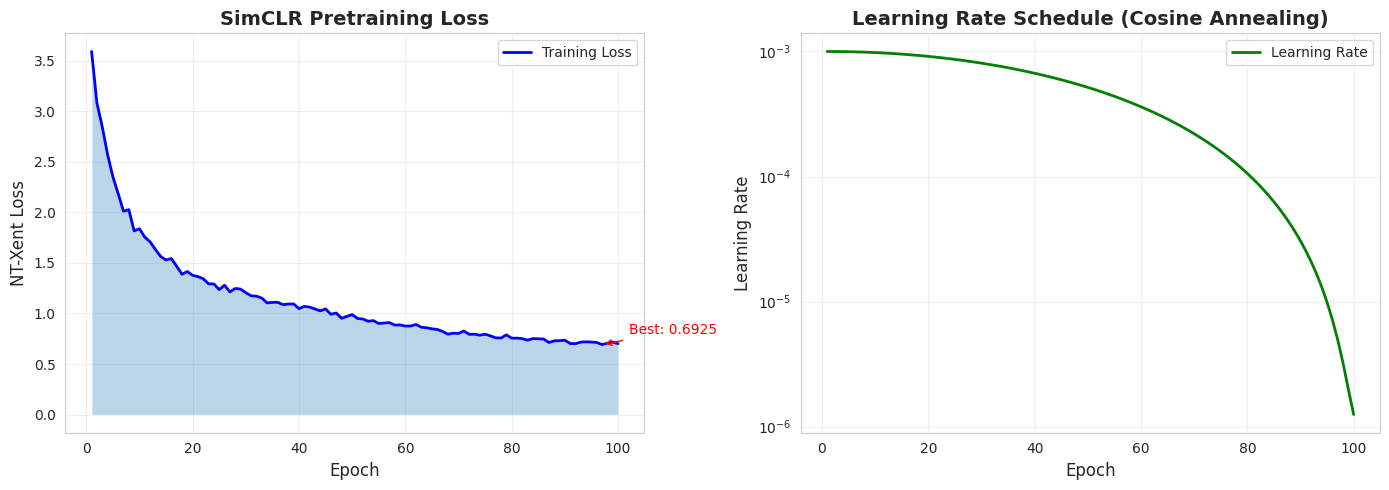

💾 Saved: /kaggle/working/03_1_SimCLR_Pretraining/simclr_training_curves.png


In [11]:
def plot_training_curves(history):
    """
    Plot training loss and learning rate curves.
    
    These plots help us understand:
    - If the model is learning (loss should decrease)
    - If training is stable (no sudden spikes)
    - How the learning rate schedule affects training
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss curve
    axes[0].plot(history['epoch'], history['loss'], 'b-', linewidth=2, label='Training Loss')
    axes[0].fill_between(history['epoch'], history['loss'], alpha=0.3)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('NT-Xent Loss', fontsize=12)
    axes[0].set_title('SimCLR Pretraining Loss', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    
    # Add annotations
    min_loss = min(history['loss'])
    min_epoch = history['epoch'][history['loss'].index(min_loss)]
    axes[0].annotate(f'Best: {min_loss:.4f}', 
                     xy=(min_epoch, min_loss),
                     xytext=(min_epoch + 5, min_loss + 0.1),
                     arrowprops=dict(arrowstyle='->', color='red'),
                     fontsize=10, color='red')
    
    # Learning rate curve
    axes[1].plot(history['epoch'], history['lr'], 'g-', linewidth=2, label='Learning Rate')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Learning Rate', fontsize=12)
    axes[1].set_title('Learning Rate Schedule (Cosine Annealing)', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    axes[1].set_yscale('log')
    
    plt.tight_layout()
    plt.savefig(config.OUTPUT_DIR / 'simclr_training_curves.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"💾 Saved: {config.OUTPUT_DIR / 'simclr_training_curves.png'}")

plot_training_curves(history)

### Understanding the Training Curves:

**Loss Curve (Left):**
- **Decreasing loss** indicates the model is learning to bring positive pairs together and push negative pairs apart
- **Smooth decrease** suggests stable training
- The **best loss point** is marked - this is where the model learned the best representations

**Learning Rate Curve (Right):**
- **Cosine annealing** starts with higher LR for fast learning, then gradually decreases for fine-tuning
- This schedule helps avoid local minima early and converge to better solutions later

## 9. Save Pretrained Model

In [12]:
# Save the pretrained encoder (for finetuning notebook)
encoder_save_path = config.OUTPUT_DIR / config.MODEL_SAVE_NAME

# Save only the encoder state dict
torch.save({
    'encoder_state_dict': model.encoder.state_dict(),
    'feature_dim': model.feature_dim,
    'backbone': config.BACKBONE,
    'config': {
        'img_size': config.IMG_SIZE,
        'projection_dim': config.PROJECTION_DIM,
        'hidden_dim': config.HIDDEN_DIM,
        'temperature': config.TEMPERATURE,
        'epochs_trained': config.EPOCHS
    }
}, encoder_save_path)

print(f"✅ Pretrained encoder saved: {encoder_save_path}")

# Save full model (for reference)
full_model_save_path = config.OUTPUT_DIR / config.FULL_MODEL_SAVE_NAME
torch.save(model.state_dict(), full_model_save_path)
print(f"✅ Full model saved: {full_model_save_path}")

# Save training history
history_df = pd.DataFrame(history)
history_df.to_csv(config.OUTPUT_DIR / 'simclr_training_history.csv', index=False)
print(f"✅ Training history saved: {config.OUTPUT_DIR / 'simclr_training_history.csv'}")

✅ Pretrained encoder saved: /kaggle/working/03_1_SimCLR_Pretraining/simclr_backbone.pth
✅ Full model saved: /kaggle/working/03_1_SimCLR_Pretraining/simclr_full_model.pth
✅ Training history saved: /kaggle/working/03_1_SimCLR_Pretraining/simclr_training_history.csv


## 10. Feature Quality Analysis

Let's visualize the learned representations using t-SNE to see if the model has learned meaningful features.


🔍 Extracting features for visualization...
   Extracted features shape: (320, 512)
Computing PCA...
Computing t-SNE (this may take a moment)...


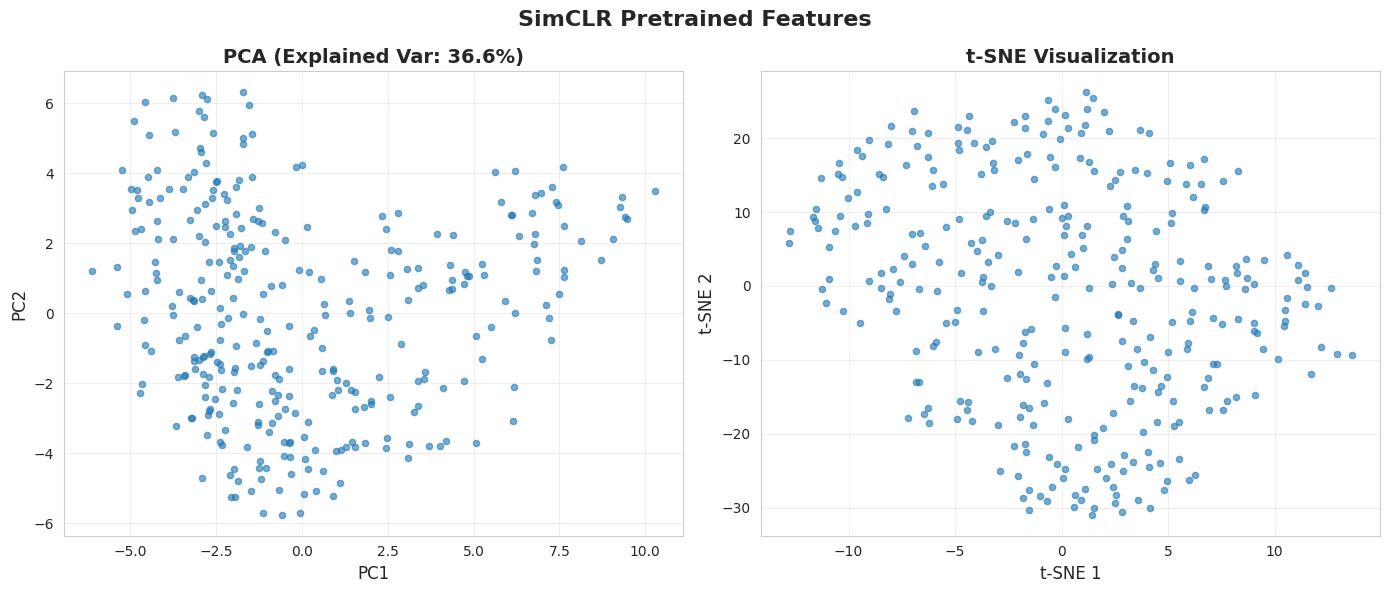

💾 Saved: /kaggle/working/03_1_SimCLR_Pretraining/simclr_feature_visualization.png


In [13]:
@torch.no_grad()
def extract_features(model, dataloader, num_batches=10):
    """
    Extract features from the pretrained encoder.
    """
    model.eval()
    features = []
    
    for batch_idx, (view1, view2) in enumerate(dataloader):
        if batch_idx >= num_batches:
            break
        
        view1 = view1.to(device)
        h, _ = model(view1)
        features.append(h.cpu().numpy())
    
    return np.concatenate(features, axis=0)


def visualize_feature_space(features, title='Feature Space Visualization'):
    """
    Visualize high-dimensional features in 2D using t-SNE and PCA.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # PCA
    print("Computing PCA...")
    pca = PCA(n_components=2, random_state=42)
    features_pca = pca.fit_transform(features)
    
    axes[0].scatter(features_pca[:, 0], features_pca[:, 1], alpha=0.6, s=20)
    axes[0].set_xlabel('PC1', fontsize=12)
    axes[0].set_ylabel('PC2', fontsize=12)
    axes[0].set_title(f'PCA (Explained Var: {sum(pca.explained_variance_ratio_)*100:.1f}%)', 
                      fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # t-SNE
    print("Computing t-SNE (this may take a moment)...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    features_tsne = tsne.fit_transform(features)
    
    axes[1].scatter(features_tsne[:, 0], features_tsne[:, 1], alpha=0.6, s=20)
    axes[1].set_xlabel('t-SNE 1', fontsize=12)
    axes[1].set_ylabel('t-SNE 2', fontsize=12)
    axes[1].set_title('t-SNE Visualization', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(config.OUTPUT_DIR / 'simclr_feature_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"💾 Saved: {config.OUTPUT_DIR / 'simclr_feature_visualization.png'}")


# Extract and visualize features
print("\n🔍 Extracting features for visualization...")
features = extract_features(model, train_loader, num_batches=10)
print(f"   Extracted features shape: {features.shape}")

visualize_feature_space(features, title='SimCLR Pretrained Features')

### Understanding the Feature Visualization:

**PCA (Left):**
- Shows the main axes of variation in the learned features
- Explained variance tells us how much information is captured in 2D

**t-SNE (Right):**
- Reveals local structure and clusters in the feature space
- If similar images cluster together, the model learned meaningful representations
- Clear clusters suggest the features capture semantic information

**Note:** Since this is unsupervised pretraining (no labels), we don't color by class here. The clustering structure comes purely from the learned representations.

In [14]:
# Final summary
print("\n" + "="*70)
print("📋 SIMCLR PRETRAINING SUMMARY")
print("="*70)
print(f"""
🔧 CONFIGURATION:
   Backbone: {config.BACKBONE}
   Feature Dimension: {model.feature_dim}
   Projection Dimension: {config.PROJECTION_DIM}
   Temperature: {config.TEMPERATURE}
   Epochs: {config.EPOCHS}

📈 TRAINING RESULTS:
   Initial Loss: {history['loss'][0]:.4f}
   Final Loss: {history['loss'][-1]:.4f}
   Best Loss: {min(history['loss']):.4f}

💾 SAVED FILES:
   - {config.MODEL_SAVE_NAME} (Encoder for finetuning)
   - {config.FULL_MODEL_SAVE_NAME} (Full model)
   - simclr_training_history.csv
   - simclr_training_curves.png
   - simclr_feature_visualization.png
   - simclr_augmentation_pairs.png

🚀 NEXT STEPS:
   1. Open '03_2_SimCLR_Finetuning.ipynb'
   2. Load the pretrained encoder: {config.MODEL_SAVE_NAME}
   3. Fine-tune for downstream classification tasks
""")
print("="*70)


📋 SIMCLR PRETRAINING SUMMARY

🔧 CONFIGURATION:
   Backbone: resnet18
   Feature Dimension: 512
   Projection Dimension: 128
   Temperature: 0.2
   Epochs: 100

📈 TRAINING RESULTS:
   Initial Loss: 3.5922
   Final Loss: 0.7014
   Best Loss: 0.6925

💾 SAVED FILES:
   - simclr_backbone.pth (Encoder for finetuning)
   - simclr_full_model.pth (Full model)
   - simclr_training_history.csv
   - simclr_training_curves.png
   - simclr_feature_visualization.png
   - simclr_augmentation_pairs.png

🚀 NEXT STEPS:
   1. Open '03_2_SimCLR_Finetuning.ipynb'
   2. Load the pretrained encoder: simclr_backbone.pth
   3. Fine-tune for downstream classification tasks

